# Step 5: Data Wrangling & Exploration
## Dataset: DeepFashion

### MLE Capstone: Outfit Recommender - Spring 2021
### By: Bazeley, Mikiko 
### GH: [@mmbazel](https://github.com/MMBazel)  

In this notebook, I'll be exploring one of three datasets (DeepFashion, Paperdoll, and iMaterialist). 

Specifically in this notebook we'll: 

☑️ Cleaning the data

☑️ Dealing with missing	values

☑️ Handling outliers

☑️ Dealing with class imbalance

<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

## Explanation of the data, according to the dataset page here: 
http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html


### Files/Folders:
* Anno_coarse (16.6 MB)/
        * list_attr_cloth.txt
        * list_attr_img.txt
        * list_bbox.txt
        * list_category_cloth.txt
        * list_category_img.txt
        * list_landmarks.txt
        
* Anno_fine/
        * (see all files above)
        * train_attr.txt, train_bbox.txt, train_cate.txt, train_landmarks.txt, train.txt
        * test_attr.txt, test_bbox.txt, test_cate.txt, test_landmarks.txt, test.txt
        * val_attr.txt, val_bbox.txt, val_cate.txt, val_landmarks.txt, val.txt
* Eval/
        * list_eval_partition.txt
* Img/
        * img_highres.zip (28 GB)
        * img.zip (2 GB)



### ⚠️📝 Notes (About the Notebooks) ⚠️📝 

My guiding principles:
* ➡️ Be overly communicative = While that leads to verbose commenting, I hope that means I catch a bunch of questions early)  
* ➡️ Human-readable over witty-optimization = For the most part I try to make everything I'm doing obvious
* ➡️ Write as much code as needed, and no more = There's a time and place for error-catching & object-oriented code & there are ways to make the notebook reproducible. That's not quite the goal for this notebook (or any of the other notebooks in the early stages of the project) and my goal was to write just the code needed to get this step done.  

<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style='background :red' > Step 1: Proper set-up & installation of necessary libraries & packages </span> 


In [1]:
#!pip3 install lmdb
#!pip3 install ipython-sql
#!brew install wget

In [2]:
##################### [TODO] SETUP #####################
# [TODO] Import any utilities functions


import json
import os
import sys
from sqlalchemy import create_engine

import io
import lmdb
import sqlite3
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
%load_ext sql

print('Packages Imported')

modules = dir()

print(modules)
#print(os.environ)

# [TODO] Package install/load

Packages Imported
['Image', 'In', 'Out', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'create_engine', 'exit', 'get_ipython', 'io', 'json', 'lmdb', 'np', 'os', 'pd', 'plt', 'quit', 'sqlite3', 'sys']


In [3]:
# Confirm all the right libraries are present
# This is an important step because there's a good chance
# that for some pckaes where you use pip or pip3 install
# they could download to the wrong directory if you're not
# using the right pip executable

!conda list

# packages in environment at /Users/mikikobazeley/opt/anaconda3/envs/SPRINGBOARD_MLE_CAPSTONE_ENV:
#
# Name                    Version                   Build  Channel
_py-xgboost-mutex         2.0                       cpu_0  
_pytorch_select           0.1                       cpu_0    anaconda
_tflow_select             2.3.0                       mkl  
absl-py                   0.11.0             pyhd3eb1b0_1  
appnope                   0.1.2           py37hecd8cb5_1001  
argon2-cffi               20.1.0           py37haf1e3a3_1    anaconda
astor                     0.8.1            py37hecd8cb5_0  
async_generator           1.10             py37h28b3542_0    anaconda
attrs                     20.3.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach                    3.3.0              pyhd3eb1b0_0  
blis                      0.7.4                    pypi_0    pypi
brotlipy      

In [4]:
# Confirm path of working directory
!pwd 

/Users/mikikobazeley/Github/personal/MMBazel/Wardrobe-Recommender/notebooks/Step2_EDA


<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style='background :red' > Step 2: Download the DeepFashion Dataset from GDrive</span> 

⚠️ Best way is to download the Google Drive folder you want (in this case, "Category and Attribute Prediction Benchmark") as a zipped folder and then unzip to an external (as opposed to locally). The size will kill Jupyter locally and massively slow down you computer if you don't have enough memory.

💡 Make sure to download the files manually -- Google Drive doesn't allow programmatically accessing the download link anymore: https://drive.google.com/drive/folders/0B7EVK8r0v71pWGplNFhjc01NbzQ?usp=sharing

## <span style='background :orange' > Check Datasets Downloaded Properly </span> 

In [5]:
# Note: I chose to download everything to an external
# First check that we have a folder for the Category & Attribute datasets
# If not create using:

#!mkdir <path-to-DeepFashion-Folder-on-your-external>/Category_and_Attribute_Prediction_Benchmark
!ls /Volumes/MiniGator/Projects/Datasets/DeepFashion

Category_and_Attribute_Prediction_Benchmark


In [6]:
# List files, marking whic ones are files vs folders

!ls -F /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark

Anno_coarse/ Anno_fine/   Eval/        Images/


In [7]:
# Check in the images folder

!ls -F /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Images

img/             img.zip*         img_highres/     img_highres.zip*


## <span style='background :orange' > Unzip files </span> 

In [8]:
# Unzip all files ending in .zip 
# to DeepFashion/Category_and_Attribute_Prediction_Benchmark folder
# on external drive

#<Uncomment below>
#!unzip /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/\*.zip -d /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark

In [9]:
# Remove the .zip files

#<Uncomment below>
#!rm /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/*.zip

In [10]:
# Check existing files

!ls -F /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark

Anno_coarse/ Anno_fine/   Eval/        Images/


In [11]:
# Now we'll unzip the images

#<Uncomment below>
#!unzip /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Images/img.zip -d /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Images/

In [12]:
# Now we'll unzip the images

#<Uncomment below>
#!unzip /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Images/img_highres.zip -d /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Images/

## <span style='background :orange' > Let's confirm number of images 🧙‍♀️ 📸 </span> 

In [13]:
# Let's get count number of folders of high res images
!ls /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Images/img_highres | wc -l

    5620


In [14]:
# Let's get count number of folders of regular res images
!ls /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Images/img | wc -l

    4807


<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style='background :red' > Step 3: Use CLI to start initial exploration 🔬  </span> 

We want to understand:

☑️ The data repository structure

☑️ Number of files, types of files

☑️ Type of information being captured & how it's represented 



<span style='background :yellow' > 💡 Given the size of the dataset, doing initial inspection with shell is fast & easy.
No need to break Jupyter before even getting started.  </span> 

## <span style='background :orange' > Let's get into the text files 📒 for the Anno_coarse repo </span> 

In [15]:
!ls -F /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/

list_attr_cloth.txt*     list_bbox.txt*           list_category_img.txt*
list_attr_img.txt*       list_category_cloth.txt* list_landmarks.txt*


### <span style='background :yellow' > 📙  File no.1: list_attr_cloth.txt  </span> 

---------------------------------------------------
📝 Notes according to dataset README.txt:

--------------- list_attr_cloth.txt --------------

* First Row: number of attributes
* Second Row: entry names

Rest of the Rows: [attribute name] [attribute type]
    


Notes:
1. In attribute type, "1" represents texture-related attributes, "2" represents fabric-related attributes, "3" represents shape-related attributes, "4" represents part-related attributes, "5" represents style-related attributes;
2. The order of attribute labels accords with the order of attribute names;
3. In attribute labels, "1" represents positive while "-1" represents negative, '0' represents unknown;
4. Attribute prediction is treated as a multi-label tagging problem.


In [16]:
# Let preview file: list_attr_cloth.txt
!head -n 10 /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_attr_cloth.txt

1000
attribute_name  attribute_type
a-line                       3
abstract                     1
abstract chevron             1
abstract chevron print       1
abstract diamond             1
abstract floral              1
abstract floral print        1
abstract geo                 1


In [17]:
!tail -n 10 /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_attr_cloth.txt

zeppelin                     5
zig                          1
zigzag                       1
zip                          4
zip-front                    4
zip-pocket                   4
zip-up                       4
zipped                       4
zipper                       4
zippered                     4


### <span style='background :yellow' > 📙  File no.2: list_attr_img.txt  </span> 

---------------------------------------------------
📝 Notes according to dataset README.txt:

--------------- list_attr_img.txt --------------

* First Row: number of images
* Second Row: entry names

Rest of the Rows: [image name] [attribute labels]
    


Notes:
1. In attribute type, "1" represents texture-related attributes, "2" represents fabric-related attributes, "3" represents shape-related attributes, "4" represents part-related attributes, "5" represents style-related attributes;
2. The order of attribute labels accords with the order of attribute names;
3. In attribute labels, "1" represents positive while "-1" represents negative, '0' represents unknown;
4. Attribute prediction is treated as a multi-label tagging problem.

In [18]:
# Let preview file: list_attr_img.tx
!head -n 3 /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_attr_img.txt

289222
image_name  attribute_labels
img/Sheer_Pleated-Front_Blouse/img_00000001.jpg                        -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [19]:
!tail -n 3 /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_attr_img.txt

img/Paisley_Print_Babydoll_Dress/img_00000052.jpg                      -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

### <span style='background :yellow' > 📙  File no.3: list_category_cloth.txt </span> 

---------------------------------------------------
📝 Notes according to dataset README.txt:

--------------- list_category_cloth.txt --------------

* First Row: number of categories
* Second Row: entry names

Rest of the Rows: [category name] [category type]
    
Notes:
1. In category type, "1" represents upper-body clothes, "2" represents lower-body clothes, "3" represents full-body clothes;
2. The order of category labels accords with the order of category names;
3. In category labels, the number represents the category id in category names;
4. For the clothing categories, "Cape", "Nightdress", "Shirtdress" and "Sundress" have been merged into "Dress";
5. Category prediction is treated as a 1-of-K classification problem.


In [20]:
# Let preview file: list_attr_cloth.txt
!head -n 10 /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_category_cloth.txt

50
category_name  category_type
Anorak         1
Blazer         1
Blouse         1
Bomber         1
Button-Down    1
Cardigan       1
Flannel        1
Halter         1


In [21]:
!tail -n 10 /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_category_cloth.txt

Dress          3
Jumpsuit       3
Kaftan         3
Kimono         3
Nightdress     3
Onesie         3
Robe           3
Romper         3
Shirtdress     3
Sundress       3


### <span style='background :yellow' > 📙  File no.4: list_category_img.txt </span> 

---------------------------------------------------
📝 Notes according to dataset README.txt:

--------------- list_category_img.txt --------------

* First Row: number of images
* Second Row: entry names

Rest of the Rows: [image name] [category label]
    
Notes:
1. In category type, "1" represents upper-body clothes, "2" represents lower-body clothes, "3" represents full-body clothes;
2. The order of category labels accords with the order of category names;
3. In category labels, the number represents the category id in category names;
4. For the clothing categories, "Cape", "Nightdress", "Shirtdress" and "Sundress" have been merged into "Dress";
5. Category prediction is treated as a 1-of-K classification problem.


In [22]:
# Let preview file: list_attr_cloth.txt
!head -n 10 /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_category_img.txt

289222
image_name  category_label
img/Sheer_Pleated-Front_Blouse/img_00000001.jpg                        3
img/Sheer_Pleated-Front_Blouse/img_00000002.jpg                        3
img/Sheer_Pleated-Front_Blouse/img_00000003.jpg                        3
img/Sheer_Pleated-Front_Blouse/img_00000004.jpg                        3
img/Sheer_Pleated-Front_Blouse/img_00000005.jpg                        3
img/Sheer_Pleated-Front_Blouse/img_00000006.jpg                        3
img/Sheer_Pleated-Front_Blouse/img_00000007.jpg                        3
img/Sheer_Pleated-Front_Blouse/img_00000008.jpg                        3


In [23]:
!tail -n 10 /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_category_img.txt

img/Paisley_Print_Babydoll_Dress/img_00000045.jpg                      41
img/Paisley_Print_Babydoll_Dress/img_00000046.jpg                      41
img/Paisley_Print_Babydoll_Dress/img_00000047.jpg                      41
img/Paisley_Print_Babydoll_Dress/img_00000048.jpg                      41
img/Paisley_Print_Babydoll_Dress/img_00000049.jpg                      41
img/Paisley_Print_Babydoll_Dress/img_00000050.jpg                      41
img/Paisley_Print_Babydoll_Dress/img_00000051.jpg                      41
img/Paisley_Print_Babydoll_Dress/img_00000052.jpg                      41
img/Paisley_Print_Babydoll_Dress/img_00000053.jpg                      41
img/Paisley_Print_Babydoll_Dress/img_00000054.jpg                      41


### <span style='background :yellow' > 📙  File no.5: list_landmarks.txt </span> 

---------------------------------------------------
📝 Notes according to dataset README.txt:

------------ list_landmarks.txt ------------

First Row: number of images
Second Row: entry names

Rest of the Rows: [image name] [clothes type] [variation type] [landmark visibility 1] [landmark location x_1] [landmark location y_1], ... [landmark visibility 8] [landmark location x_8] [landmark location y_8>]

---------------------------------------------------

Notes:
1. The order of landmark labels accords with the order of entry names;
2. In clothes type, "1" represents upper-body clothes, "2" represents lower-body clothes, "3" represents full-body clothes. Upper-body clothes possess six fahsion landmarks, lower-body clothes possess four fashion landmarks, full-body clothes possess eight fashion landmarks;
3. In variation type, "1" represents normal pose, "2" represents medium pose, "3" represents large pose, "4" represents medium zoom-in, "5" represents large zoom-in;
4. In landmark visibility state, "0" represents visible, "1" represents invisible/occluded, "2" represents truncated/cut-off;
5. For upper-body clothes, landmark annotations are listed in the order of ["left collar", "right collar", "left sleeve", "right sleeve", "left hem", "right hem"]; For lower-body clothes, landmark annotations are listed in the order of ["left waistline", "right waistline", "left hem", "right hem"]; For upper-body clothes, landmark annotations are listed in the order of ["left collar", "right collar", "left sleeve", "right sleeve", "left waistline", "right waistline", "left hem", "right hem"].


In [24]:
# Let preview file: list_attr_cloth.txt
!head -n 10 /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_landmarks.txt

289222
image_name  clothes_type  variation_type  landmark_visibility_1 landmark_location_x_1 landmark_location_y_1  landmark_visibility_2 landmark_location_x_2 landmark_location_y_2  landmark_visibility_3 landmark_location_x_3 landmark_location_y_3  landmark_visibility_4 landmark_location_x_4 landmark_location_y_4  landmark_visibility_5 landmark_location_x_5 landmark_location_y_5  landmark_visibility_6 landmark_location_x_6 landmark_location_y_6  landmark_visibility_7 landmark_location_x_7 landmark_location_y_7  landmark_visibility_8 landmark_location_x_8 landmark_location_y_8 
img/Sheer_Pleated-Front_Blouse/img_00000001.jpg                         1  0 146 102  0 173 095  0 094 242  0 205 255  0 136 229  0 177 232 
img/Sheer_Pleated-Front_Blouse/img_00000002.jpg                         1  0 107 067  0 122 067  0 079 078  0 140 091  0 106 150  0 134 152 
img/Sheer_Pleated-Front_Blouse/img_00000003.jpg                         1  0 101 079  0 116 076  0 078 081  0 141 084  0 087 188  0 1

In [25]:
!tail -n 10 /Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_landmarks.txt

img/Paisley_Print_Babydoll_Dress/img_00000045.jpg                       3  1 061 051  1 095 054  0 029 116  0 127 119  1 042 115  0 101 116  0 072 186  0 108 189 
img/Paisley_Print_Babydoll_Dress/img_00000046.jpg                       3  1 118 073  0 180 074  1 118 112  0 177 109  0 107 165  0 189 161  0 098 278  0 222 264 
img/Paisley_Print_Babydoll_Dress/img_00000047.jpg                       3  0 083 030  0 125 043  0 070 028  0 135 048  0 054 110  0 134 119  0 032 225  0 169 227 
img/Paisley_Print_Babydoll_Dress/img_00000048.jpg                       3  0 099 102  0 130 105  0 055 135  0 159 147  0 079 181  0 151 175  0 088 293  0 148 292 
img/Paisley_Print_Babydoll_Dress/img_00000049.jpg                       3  1 079 073  0 131 077  0 046 183  0 166 185  0 066 166  0 138 164  0 051 268  0 161 261 
img/Paisley_Print_Babydoll_Dress/img_00000050.jpg                       3  0 101 026  1 185 028  0 062 123  0 223 104  0 098 150  0 197 144  2 000 000  2 000 000 
img/Paisley_Print_Baby

## <span style='background :orange' > Let's create 🐼 dataframes & start merging & analyzing </span> 

### <span style='background :yellow' > 📈 DF no.1: Images + Attributes Dataframe </span> 

In [26]:
#create & preview df of attrbiute names & type label
list_attr_cloth_df = pd.read_table('/Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_attr_cloth.txt',
                                   sep='\s{2,}', 
                                   header=0, 
                                   skiprows=[0], 
                                   engine='python')
list_attr_cloth_df

,attribute_name,attribute_type
0,a-line,3
1,abstract,1
2,abstract chevron,1
3,abstract chevron print,1
4,abstract diamond,1
...,...,...
995,zip-pocket,4
996,zip-up,4
997,zipped,4
998,zipper,4


In [27]:
list_attr_img_df = pd.read_csv(
    '/Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_attr_img.txt', 
    delim_whitespace=True, 
    header=0,
    skiprows=[0],
    names=(['image_name'] + list_attr_cloth_df['attribute_name'].tolist()))
list_attr_img_df

,image_name,a-line,abstract,abstract chevron,abstract chevron print,abstract diamond,abstract floral,abstract floral print,abstract geo,abstract geo print,...,zeppelin,zig,zigzag,zip,zip-front,zip-pocket,zip-up,zipped,zipper,zippered
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289217,img/Paisley_Print_Babydoll_Dress/img_00000050.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
289218,img/Paisley_Print_Babydoll_Dress/img_00000051.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
289219,img/Paisley_Print_Babydoll_Dress/img_00000052.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
289220,img/Paisley_Print_Babydoll_Dress/img_00000053.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [28]:
# In attribute labels, "1" represents positive while "-1" represents negative, '0' represents unknown
# We'll replace 
list_attr_img_df.replace([-1,0,1],[False,False,True], inplace=True)

In [29]:
list_attr_img_df

,image_name,a-line,abstract,abstract chevron,abstract chevron print,abstract diamond,abstract floral,abstract floral print,abstract geo,abstract geo print,...,zeppelin,zig,zigzag,zip,zip-front,zip-pocket,zip-up,zipped,zipper,zippered
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289217,img/Paisley_Print_Babydoll_Dress/img_00000050.jpg,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
289218,img/Paisley_Print_Babydoll_Dress/img_00000051.jpg,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
289219,img/Paisley_Print_Babydoll_Dress/img_00000052.jpg,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
289220,img/Paisley_Print_Babydoll_Dress/img_00000053.jpg,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### <span style='background :yellow' > 📈 DF no.2: Images + Categories Dataframe </span> 

⚠️ One big issues: We're missing some categories of clothing.

Clothing categories file contains 50 entries, whereas the image_category_cloth file is only showing 48. We're specifically missing 'shitdress' and 'sundress'. 


📝 This can posible be explained by the note:

"For the clothing categories, "Cape", "Nightdress", "Shirtdress" and "Sundress" have been merged into "Dress""

In [30]:
#create & preview df of attrbiute names & type label
list_category_cloth_df = pd.read_table('/Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_category_cloth.txt',
                                   sep='\s{2,}', 
                                   header=0, 
                                   skiprows=[0], 
                                   engine='python')
list_category_cloth_df.head(10)

,category_name,category_type
0,Anorak,1
1,Blazer,1
2,Blouse,1
3,Bomber,1
4,Button-Down,1
5,Cardigan,1
6,Flannel,1
7,Halter,1
8,Henley,1
9,Hoodie,1


In [31]:
list_category_cloth_df.describe()

,category_type
count,50.000000
mean,1.880000
std,0.824126
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,3.000000


In [32]:
#create & preview df of attrbiute names & type label
list_category_img_df = pd.read_table('/Volumes/MiniGator/Projects/Datasets/DeepFashion/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_category_img.txt',
                                   sep='\s{2,}', 
                                   header=0, 
                                   skiprows=[0], 
                                   engine='python')
list_category_img_df.head(10)

,image_name,category_label
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3.0
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3.0
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3.0
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3.0
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3.0
5,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,3.0
6,img/Sheer_Pleated-Front_Blouse/img_00000007.jpg,3.0
7,img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,3.0
8,img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,3.0
9,img/Sheer_Pleated-Front_Blouse/img_00000010.jpg,3.0


In [33]:
# Notice that the highest category goes to 48 only.

list_category_img_df['category_label'].describe()

count    289185.000000
mean         25.209893
std          14.026095
min           1.000000
25%          16.000000
50%          26.000000
75%          41.000000
max          48.000000
Name: category_label, dtype: float64

In [34]:
list_category_img_df.loc[list_category_img_df['category_label']==1.0]

,image_name,category_label
22595,img/Hooded_Cotton_Canvas_Anorak/img_00000001.jpg,1.0
22596,img/Hooded_Cotton_Canvas_Anorak/img_00000002.jpg,1.0
22597,img/Hooded_Cotton_Canvas_Anorak/img_00000003.jpg,1.0
22598,img/Hooded_Cotton_Canvas_Anorak/img_00000004.jpg,1.0
22599,img/Hooded_Cotton_Canvas_Anorak/img_00000005.jpg,1.0
...,...,...
22750,img/Hooded_Cotton_Canvas_Anorak/img_00000157.jpg,1.0
22751,img/Hooded_Cotton_Canvas_Anorak/img_00000158.jpg,1.0
22752,img/Hooded_Cotton_Canvas_Anorak/img_00000159.jpg,1.0
22753,img/Hooded_Cotton_Canvas_Anorak/img_00000160.jpg,1.0


In [35]:
list_category_img_df.loc[list_category_img_df['category_label']==48.0]

,image_name,category_label
199045,img/Open-Back_Woven_Romper/img_00000001.jpg,48.0
199046,img/Open-Back_Woven_Romper/img_00000002.jpg,48.0
199047,img/Open-Back_Woven_Romper/img_00000003.jpg,48.0
199048,img/Open-Back_Woven_Romper/img_00000004.jpg,48.0
199049,img/Open-Back_Woven_Romper/img_00000005.jpg,48.0
...,...,...
288782,img/Cutout_Back_Textured_Romper/img_00000030.jpg,48.0
288783,img/Cutout_Back_Textured_Romper/img_00000031.jpg,48.0
288784,img/Cutout_Back_Textured_Romper/img_00000032.jpg,48.0
288785,img/Cutout_Back_Textured_Romper/img_00000033.jpg,48.0


<AxesSubplot:ylabel='category_label'>

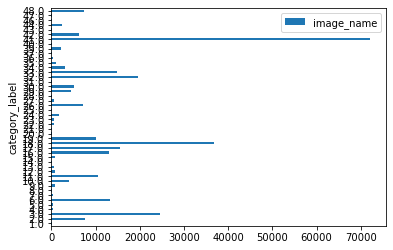

In [36]:
(list_category_img_df
 .groupby('category_label')
 .count()
 .reset_index()
 .set_index('category_label')
 .plot(kind='barh', y='image_name',use_index=True)
)

In [37]:
# Create a column that has the actual category labels
list_category_cloth_df['actual_category_number'] = np.arange(1,len(list_category_cloth_df)+1)
img_categories_combined_df = list_category_img_df.merge(list_category_cloth_df, how='left',left_on='category_label',right_on='actual_category_number')
img_categories_combined_df

,image_name,category_label,category_name,category_type,actual_category_number
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3.0,Blouse,1.0,3.0
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3.0,Blouse,1.0,3.0
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3.0,Blouse,1.0,3.0
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3.0,Blouse,1.0,3.0
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3.0,Blouse,1.0,3.0
...,...,...,...,...,...
289217,img/Paisley_Print_Babydoll_Dress/img_00000050.jpg,41.0,Dress,3.0,41.0
289218,img/Paisley_Print_Babydoll_Dress/img_00000051.jpg,41.0,Dress,3.0,41.0
289219,img/Paisley_Print_Babydoll_Dress/img_00000052.jpg,41.0,Dress,3.0,41.0
289220,img/Paisley_Print_Babydoll_Dress/img_00000053.jpg,41.0,Dress,3.0,41.0


<AxesSubplot:ylabel='category_name'>

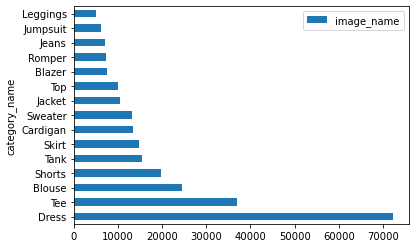

In [38]:
# Top 15 categories by images
(img_categories_combined_df
 .groupby('category_name')
 .count()
 .sort_values('image_name',ascending=False)
 .iloc[:15]
 .plot(kind='barh',y='image_name',use_index=True)
)

<AxesSubplot:ylabel='category_name'>

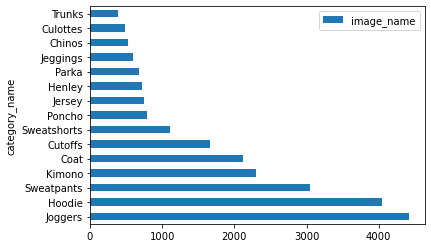

In [39]:
# Next 15 clothing categories
(img_categories_combined_df
 .groupby('category_name')
 .count()
 .sort_values('image_name',ascending=False)
 .iloc[15:30]
 .plot(kind='barh',y='image_name',use_index=True)
)

<AxesSubplot:ylabel='category_name'>

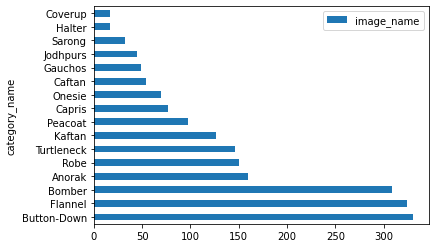

In [40]:
# Last set of clothing categories
(img_categories_combined_df
 .groupby('category_name')
 .count()
 .sort_values('image_name',ascending=False)
 .iloc[30:]
 .plot(kind='barh',y='image_name',use_index=True)
)

<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style='background :red' > Step 4A: 🔬 Deeper EDA & Exploration of the Attributes Data 📚</span> 

## <span style='background :orange' > Let's get a high-level view of the attributes 👗 data </span> 

In [41]:
# In attribute type, 
#"1" represents texture-related attributes, 
#"2" represents fabric-related attributes, 
#"3" represents shape-related attributes, 
#"4" represents part-related attributes, 
#"5" represents style-related attributes;

list_attr_cloth_df.groupby('attribute_type').count()

,attribute_name
attribute_type,
1,156
2,218
3,180
4,216
5,230


## <span style='background :orange' > 🎽 Exploring Texture Attributes </span> 

### <span style='background :yellow' > ➡️ Getting Counts & Distributions </span> 

In [42]:
texture_list = list_attr_cloth_df.loc[list_attr_cloth_df['attribute_type']==1.0]['attribute_name'].to_list()

In [43]:
texture_dict = {}
for i in texture_list:
    count_ = list_attr_img_df[i].sum()
    texture_dict[i] = count_

In [44]:
texture_df_count = (pd.DataFrame.from_dict(texture_dict,orient='index')
                    .rename(columns={0:'count_'})
                   )
texture_df_count

,count_
abstract,5643
abstract chevron,124
abstract chevron print,56
abstract diamond,53
abstract floral,434
...,...
two-tone,305
varsity-striped,213
watercolor,852
zig,234


### <span style='background :yellow' > ➡️ All by img count </span> 

<AxesSubplot:>

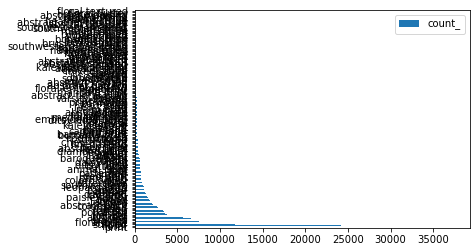

In [45]:
(texture_df_count
 .sort_values('count_',ascending=False)
 .plot(kind='barh'))

### <span style='background :yellow' > ➡️ Top 20 by img count </span> 

<AxesSubplot:>

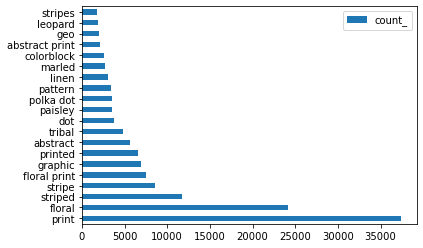

In [46]:
(texture_df_count
 .sort_values('count_',ascending=False)
 .iloc[:20]
 .plot(kind='barh'))

### <span style='background :yellow' > ➡️ Bottom 20 by img count </span> 

<AxesSubplot:>

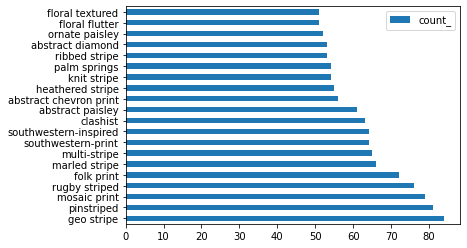

In [47]:
(texture_df_count
 .sort_values('count_',ascending=False)
 .iloc[-20:]
 .plot(kind='barh'))

## <span style='background :orange' > 🎽 Exploring Fabric Attributes </span> 

### <span style='background :yellow' > ➡️ Getting Counts & Distributions </span> 

In [48]:
fabric_list = list_attr_cloth_df.loc[list_attr_cloth_df['attribute_type']==2.0]['attribute_name'].to_list()

In [49]:
fabric_dict = {}
for i in fabric_list:
    count_ = list_attr_img_df[i].sum()
    fabric_dict[i] = count_

In [50]:
fabric_df_count = (pd.DataFrame.from_dict(fabric_dict,orient='index')
                    .rename(columns={0:'count_'})
                   )
fabric_df_count

,count_
acid,2125
acid wash,1734
applique,252
bead,248
beaded,2702
...,...
velveteen,161
waffle,553
wash,4919
washed,980


### <span style='background :yellow' > ➡️ All by img count </span> 

<AxesSubplot:>

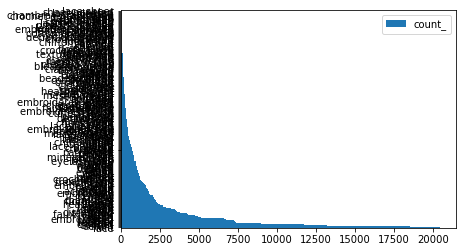

In [51]:
(fabric_df_count
 .sort_values('count_',ascending=False)
 .plot(kind='barh'))

### <span style='background :yellow' > ➡️ Top 20 by img count </span> 

<AxesSubplot:>

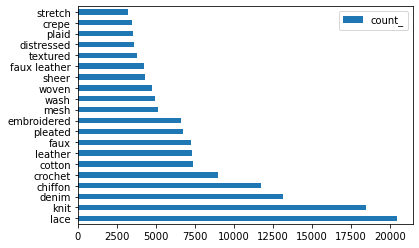

In [52]:
(fabric_df_count
 .sort_values('count_',ascending=False)
 .iloc[:20]
 .plot(kind='barh'))

### <span style='background :yellow' > ➡️ Bottom 20 by img count </span> 

<AxesSubplot:>

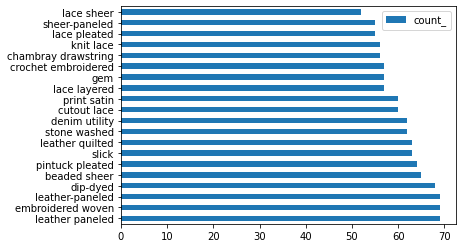

In [53]:
(fabric_df_count
 .sort_values('count_',ascending=False)
 .iloc[-20:]
 .plot(kind='barh'))

## <span style='background :orange' > 🎽 Exploring Shape Attributes </span> 

### <span style='background :yellow' > ➡️ Getting Counts & Distributions </span> 

In [54]:
shape_list = list_attr_cloth_df.loc[list_attr_cloth_df['attribute_type']==3.0]['attribute_name'].to_list()

In [55]:
shape_dict = {}
for i in shape_list:
    count_ = list_attr_img_df[i].sum()
    shape_dict[i] = count_

In [56]:
shape_df_count = (pd.DataFrame.from_dict(shape_dict,orient='index')
                    .rename(columns={0:'count_'})
                   )
shape_df_count

,count_
a-line,3240
ankle,1100
asymmetric,833
asymmetrical,1220
baja,222
...,...
vertical,399
wide-leg,252
windbreaker,126
windowpane,214


### <span style='background :yellow' > ➡️ All by img count </span> 

<AxesSubplot:>

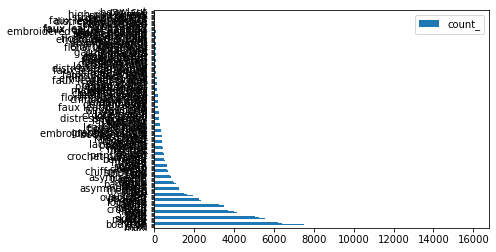

In [57]:
(shape_df_count
 .sort_values('count_',ascending=False)
 .plot(kind='barh'))

### <span style='background :yellow' > ➡️ Top 20 by img count </span> 

<AxesSubplot:>

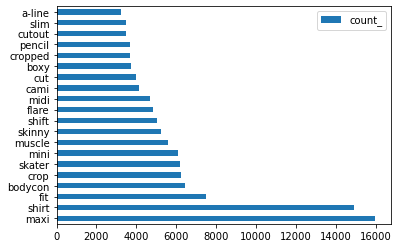

In [58]:
(shape_df_count
 .sort_values('count_',ascending=False)
 .iloc[:20]
 .plot(kind='barh'))

### <span style='background :yellow' > ➡️ Bottom 20 by img count </span> 

<AxesSubplot:>

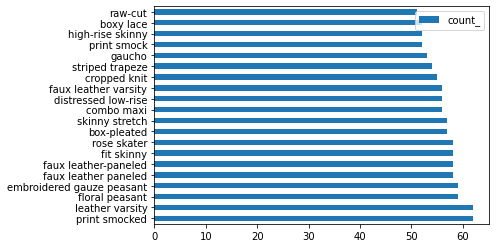

In [59]:
(shape_df_count
 .sort_values('count_',ascending=False)
 .iloc[-20:]
 .plot(kind='barh'))

## <span style='background :orange' > 🎽 Exploring Parts Attributes </span> 

### <span style='background :yellow' > ➡️ Getting Counts & Distributions </span> 

In [60]:
part_list = list_attr_cloth_df.loc[list_attr_cloth_df['attribute_type']==4.0]['attribute_name'].to_list()

In [61]:
part_dict = {}
for i in part_list:
    count_ = list_attr_img_df[i].sum()
    part_dict[i] = count_

In [62]:
part_df_count = (pd.DataFrame.from_dict(part_dict,orient='index')
                    .rename(columns={0:'count_'})
                   )
part_df_count

,count_
arrow collar,167
asymmetrical hem,194
back bow,55
back cutout,152
back knit,75
...,...
zip-pocket,75
zip-up,200
zipped,95
zipper,2006


### <span style='background :yellow' > ➡️ All by img count </span> 

<AxesSubplot:>

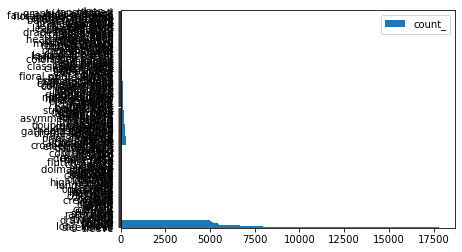

In [63]:
(part_df_count
 .sort_values('count_',ascending=False)
 .plot(kind='barh'))

### <span style='background :yellow' > ➡️ Top 20 by img count </span> 

<AxesSubplot:>

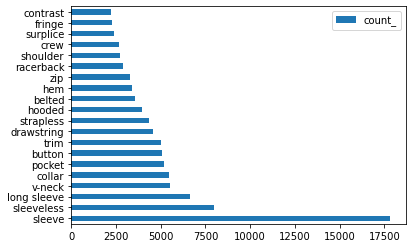

In [64]:
(part_df_count
 .sort_values('count_',ascending=False)
 .iloc[:20]
 .plot(kind='barh'))

### <span style='background :yellow' > ➡️ Bottom 20 by img count </span> 

<AxesSubplot:>

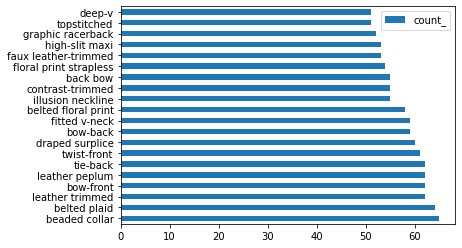

In [65]:
(part_df_count
 .sort_values('count_',ascending=False)
 .iloc[-20:]
 .plot(kind='barh'))

## <span style='background :orange' > 🎽 Exploring Style Attributes </span> 

### <span style='background :yellow' > ➡️ Getting Counts & Distributions </span> 

In [66]:
style_list = list_attr_cloth_df.loc[list_attr_cloth_df['attribute_type']==5.0]['attribute_name'].to_list()

In [67]:
style_dict = {}
for i in style_list:
    count_ = list_attr_img_df[i].sum()
    style_dict[i] = count_

In [68]:
style_df_count = (pd.DataFrame.from_dict(style_dict,orient='index')
                    .rename(columns={0:'count_'})
                   )
style_df_count

,count_
americana,103
angeles,533
art,491
athletic,1017
audrey,224
...,...
yoga,1622
yoke,558
york,1877
youth,261


### <span style='background :yellow' > ➡️ All by img count </span> 

<AxesSubplot:>

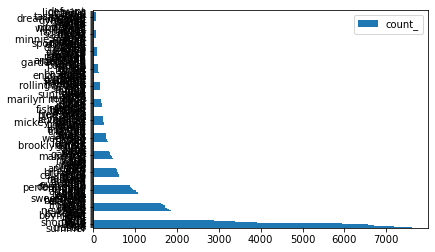

In [69]:
(style_df_count
 .sort_values('count_',ascending=False)
 .plot(kind='barh'))

### <span style='background :yellow' > ➡️ Top 20 by img count </span> 

<AxesSubplot:>

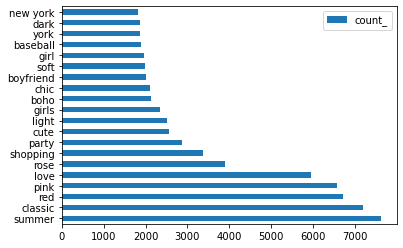

In [70]:
(style_df_count
 .sort_values('count_',ascending=False)
 .iloc[:20]
 .plot(kind='barh'))

### <span style='background :yellow' > ➡️ Bottom 20 by img count </span> 

<AxesSubplot:>

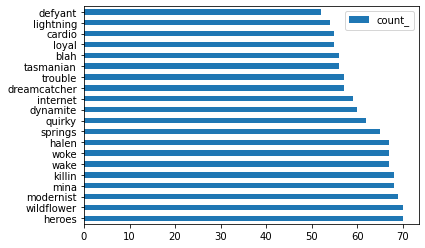

In [71]:
(style_df_count
 .sort_values('count_',ascending=False)
 .iloc[-20:]
 .plot(kind='barh'))